In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#import necessary libraries
from igraph import *
import networkx as nx
from tqdm import tqdm
from joblib import Parallel, delayed
from datetime import datetime
from matplotlib import pyplot as plt

In [9]:
# g = Graph(directed=True)
#directed graph
g = nx.DiGraph()

In [10]:
print(g)

DiGraph with 0 nodes and 0 edges


In [11]:
def humanize_unixtime(unix_time):
    time = datetime.fromtimestamp(int(unix_time)).strftime('%d-%m-%Y %H.%M.%S')
    return time

In [12]:
def get_details(input_type, month):
    
    #hashes list to store all the hashes
    details_dict = dict()
    
    #read files
    if input_type == "inputs":
        filename = "/content/drive/MyDrive/Colab Notebooks/Blockchain Data/edges2010/updated/inputs2010_{}.txt".format(str(month+2))
    if input_type == "outputs":
        filename = "/content/drive/MyDrive/Colab Notebooks/Blockchain Data/edges2010/updated/outputs2010_{}.txt".format(str(month+2))

    with open(filename) as file:
        for line in file:
            #split by tab char to get the details present
            line = line.replace('\n', '')
            details = line.split("\t")

            #hash present at the second value
            #append in the list
            details_dict[details[1]] = dict()
            
            if input_type == "inputs":
                details_dict[details[1]]['time'] = details[0]
                details_dict[details[1]]["input"] = details[2:]
                details_dict[details[1]]["human"] = humanize_unixtime(details[0])
                
            if input_type == "outputs":
                details_dict[details[1]]["output"] = details[2:]
                details_dict[details[1]]["time"] = details[0]
                details_dict[details[1]]["human"] = humanize_unixtime(details[0])
            
    return details_dict

In [13]:
#as there is data file for each month
month = 1

#input dict to store all the input details
input_dict = dict()

#output dict to store all the output details
output_dict = dict()

In [14]:
import time
start_time = time.time()

#calling function
inp = Parallel(n_jobs=-1)(delayed(get_details)("inputs", i) for i in tqdm(range(month)))
for d in inp:
    input_dict.update(d)

end_time = time.time()
print("Time taken to read the input file data is {}".format(end_time - start_time))

100%|██████████| 1/1 [00:00<00:00, 82.27it/s]


Time taken to read the input file data is 2.0204403400421143


In [15]:
print("Total details in input dict is: {}".format(len(input_dict)))

Total details in input dict is: 142


In [2]:
# input_dict

In [17]:
import time
start_time = time.time()

#calling function
inp = Parallel(n_jobs=-1)(delayed(get_details)("outputs", i) for i in tqdm(range(month)))
for d in inp:
    output_dict.update(d)

end_time = time.time()
print("Time taken to read the output file data is {}".format(end_time - start_time))

100%|██████████| 1/1 [00:00<00:00, 1184.16it/s]


Time taken to read the output file data is 0.31162524223327637


In [18]:
print("Total details in output dict is: {}".format(len(output_dict)))

Total details in output dict is: 142


In [19]:
#merge input and output data
for key, value in output_dict.items():
    input_details = input_dict[key]
    output_dict[key]["input"] = input_details["input"]

print("Total details in linked dict is: {}".format(len(output_dict)))

Total details in linked dict is: 142


In [1]:
# output_dict

In [21]:
updated_dict = dict(sorted(output_dict.items(), key=lambda item: item[1]['time']))

In [22]:
for key, value in tqdm(updated_dict.items()):
    
    #print("Current transaction hash {}".format(key))
    hash_of_transc = key
    
    
    input_details_of_hash_of_transc = value["input"]
    output_details_of_hash_of_transc = value["output"]
    
    #print("Transaction input details {}".format(input_details_of_hash_of_transc))
    #print("Transaction output details {}".format(output_details_of_hash_of_transc))
    
    #going over all input transactions
    for i in range(0, len(input_details_of_hash_of_transc), 2):
        
        input_hash = input_details_of_hash_of_transc[i]
        output_index = input_details_of_hash_of_transc[i+1]
        
        #print(input_hash)
        #print(output_index)
        if input_hash not in updated_dict.keys():
            #g.add_vertex(input_hash)
            #print("no address")
            pass
        else:
            #g.add_vertex(input_hash)
            #get output details of that input transaction
            get_amounts = updated_dict[input_hash]["output"]
            
            #print(get_amounts)
            address = get_amounts[int(output_index)]
            amount = get_amounts[2*int(output_index)+1]
            
            
            #add input transaction node
            g.add_node(input_hash, s='s', label='transaction', color="r")
            
            #add address node
            g.add_node(address, s ='s', label='address', color="b")
            
            #add output transaction node
            g.add_node(hash_of_transc, s='o', label='transaction', color="r")
            
            #add edge between input transaction and address
            g.add_edge(input_hash, address, weight=int(amount))
            
            #add edge between address and output transaction
            g.add_edge(address, key, weight=int(amount))

        
            #g.add_edge(input_hash, key, weight=amount)
            #g.add_edge(input_hash, key)
            #g.es["weights"] = amount

100%|██████████| 142/142 [00:00<00:00, 15510.99it/s]


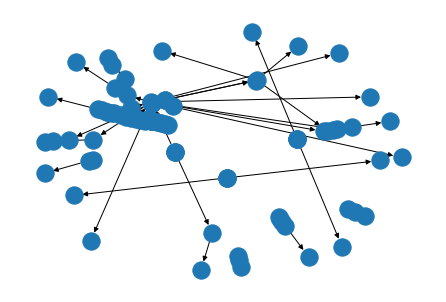

In [23]:
import matplotlib.pyplot as plt
nx.draw(g)

import pyvis

In [28]:
from pyvis.network import Network

In [29]:
net = Network(notebook = True)

In [30]:
net.from_nx(g)

In [37]:
net.show("/content/drive/MyDrive/bitcoinAddressTransactionGraph.html")